In [226]:
import imgaug as ia
import numpy as np
from PIL import Image
import cv2 as cv
from imgaug import augmenters as iaa
import numpy as np
from random import randint, uniform, shuffle
import glob

In [227]:
def xy_to_yolo_bbox(img, augmented_bbox):
    # x_center y_center width height
    
    abs_width = augmented_bbox.x2 - augmented_bbox.x1
    abs_height = augmented_bbox.y2 - augmented_bbox.y1
    
    x_center = augmented_bbox.x1 + abs_width/2
    y_center = augmented_bbox.y1 + abs_height/2
        
    img_width = img.shape[1]
    img_height = img.shape[0]    
    
    yolo_x = x_center / img_width
    yolo_y = y_center / img_height
    
    yol_w = abs_width / img_width
    yol_h = abs_height / img_height
    
    return yolo_x, yolo_y, yol_w, yol_h


def yolo_bb_to_xy(img, txt_file):
    
    yolo_bboxes = []
    
    with open(txt_file) as f:
        for line in f:
            line = line.strip()
            yolo_bboxes.append([float(x) for x in line.split(' ')[1:]])
    
    img_width = img.shape[1]
    img_height = img.shape[0]
    
    xy_bboxes = []
    
    for bbox in yolo_bboxes:
        x_center = bbox[0] * img_width
        y_center = bbox[1] * img_height

        bbox_width = bbox[2] * img_width
        bbox_height = bbox[3] * img_height

        x1 = x_center - bbox_width/2
        y1 = y_center - bbox_height/2

        x2 = x_center + bbox_width/2
        y2 = y_center + bbox_height/2
    
        
        xy_bboxes.append(ia.BoundingBox(x1=int(x1), y1=int(y1), x2=int(x2), y2=int(y2)))
    
    return ia.BoundingBoxesOnImage(xy_bboxes, shape=img.shape)

In [228]:
images = []
bboxes = []

IMAGES_DIR = 'test_images/'

for i in glob.glob(IMAGES_DIR + '/*.jpg'):
    print(i.split('.')[0])
    file_name_no_extension = i.split('.')[0]
    
    img = cv.imread(file_name_no_extension + '.jpg')
    
    bboxes.append(yolo_bb_to_xy(img, file_name_no_extension + '.txt'))
    images.append(img)

test_images/2018-10-19-222046
test_images/1
test_images/2018-10-19-222051
test_images/2018-10-19-221933


In [229]:
def display(img):
    return Image.fromarray(img[:, :, ::-1])

def Add(seq_l):
    val = randint(-45, 45)
    seq_l.append(iaa.Add(val))

def GaussianBlur(seq_l):
    val = uniform(0.0, 2.0)
    seq_l.append(iaa.GaussianBlur(val))

def Hue(seq_l):
    val = randint(-10,10)
    seq_l.append(iaa.AddToHueAndSaturation(val))

def Noise(seq_l):
    val1 = uniform(0.0, .04)
    seq_l.append(iaa.AdditiveGaussianNoise(scale=val1*225))

def Contrast(seq_l):
    val1 = uniform(.4, 1.2)
    val2 = uniform(.6, 1.4)
    seq_l.append(iaa.ContrastNormalization(alpha=(val1, val2)))


def Perp(seq_l):
    val1 = uniform(.01, .075)
    seq_l.append(iaa.PerspectiveTransform(scale=val1))
    
    
def Crop(seq_l):
    top = randint(0,10)
    right = randint(0,10)
    bottom = randint(0,10)
    left = randint(0,10)
    
def Zoom(seq_l):
    val = uniform(1.0, 1.5)
    seq_l.append(iaa.Affine(scale=val))
    

In [230]:
def augment(images, bboxs, noise, add, blur, hue, contrast, crop, zoom, perp):
    seq_l = []
    
    if noise:
        Noise(seq_l)
    if add:
        Add(seq_l)
    if blur:
        GaussianBlur(seq_l)
    if hue:
        Hue(seq_l)
    if contrast:
        Contrast(seq_l)
    if crop:
        Crop(seq_l)
    if zoom:
        Zoom(seq_l)
    if perp:
        Perp(seq_l)
    
    seq_l.append(iaa.Fliplr(.5))
    
    seq = iaa.Sequential(seq_l)
    
    seq_det = seq.to_deterministic()
    
    augmented_images = seq_det.augment_images(images)
    augmented_bboxes = seq_det.augment_bounding_boxes(bboxs)
    
    print("amount of augmentations: " + str(len(seq_l)))

    return augmented_images, augmented_bboxes

In [231]:
def generate_data(images, bboxs):
    
    result_images = []
    result_bboxes = []
    
    for i in range(10):
        augmented_images, augmented_bboxes = augment(images, bboxes, contrast=randint(0,1), hue=randint(0,1), noise=randint(0,1), add=randint(0,1),blur=randint(0,1), zoom=randint(0,1), crop=randint(0,1), perp=randint(0,1))
        
        result_images += augmented_images
        result_bboxes += augmented_bboxes
    
    return result_images, result_bboxes
        

In [232]:
augmented_images, augmented_bboxes = generate_data(images, bboxes)

amount of augmentations: 5
amount of augmentations: 4
amount of augmentations: 6
amount of augmentations: 2
amount of augmentations: 4
amount of augmentations: 8
amount of augmentations: 2
amount of augmentations: 5
amount of augmentations: 4
amount of augmentations: 7


In [233]:
AUGMENT_DIR_NAME = 'augmented_data'

for img_num, data in enumerate(zip(augmented_images, augmented_bboxes)):
    aug_img, aug_bbox = data
    
    fp = AUGMENT_DIR_NAME + '/aug' + str(img_num) + '.jpg'
    cv.imwrite(fp, aug_img)
    
    fp = AUGMENT_DIR_NAME + '/aug' + str(img_num) + '.txt'

    with open(fp, mode='w+') as f:
        for cur_bbox in aug_bbox.bounding_boxes:
            x, y, w, h = xy_to_yolo_bbox(aug_img, cur_bbox)
            
            if x < 0.0 or x > 1.0 or y < 0.0 or y > 0.0 or w < 0.0 or w > 0.0 or h < 0.0 or h > 0.0:
                continue
                
            print(x,y, w, h)
            f.write('0 %f %f %f %f\n' % (x, y ,w , h))

In [237]:
len(augmented_images)

40

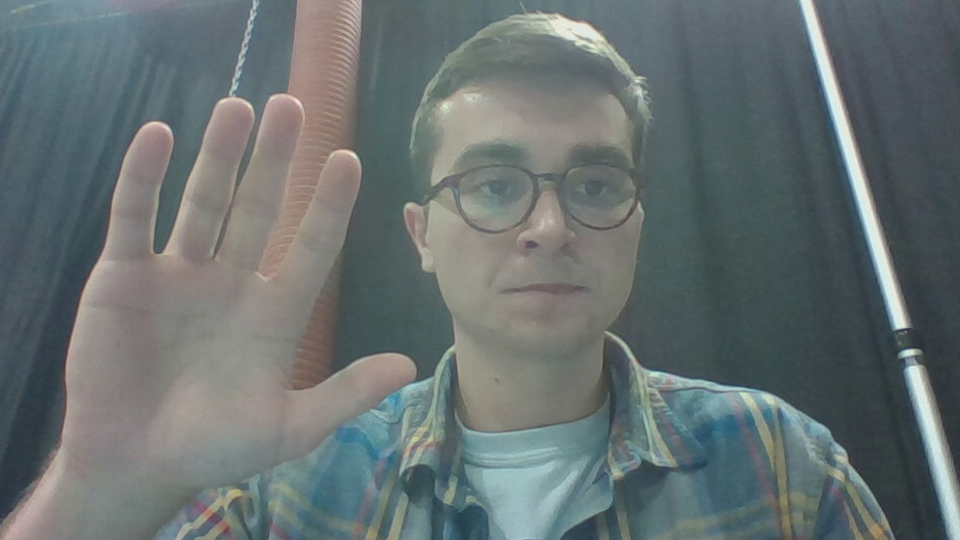

In [236]:
display(augmented_images[1])